# Dataset Description

* This notebook predict the probability that an online transaction is fraudulent. The target value is an column named by isFraud.

* The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Categorical Features - Transaction

    * ProductCD
    * card1 - card6
    * addr1, addr2
    * P_emaildomain
    * R_emaildomain
    * M1 - M9

#### Categorical Features - Identity

    * DeviceType
    * DeviceInfo
    * id_12 - id_38

#### Link to download dataset:

   * https://www.kaggle.com/competitions/ieee-fraud-detection/overview

In [5]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Transaction CSVs
train_transaction = pd.read_csv('data/train_transaction.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('data/train_identity.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [7]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [8]:
# Missing value
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
% of missing data =  41.073431200111266


In [9]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
## Reducing memory of train sets
train_transaction = reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [11]:
## Reducing memory of test sets
test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)

Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [12]:
#Summary Function
def fun_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [13]:
fun_summary(train_transaction)

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,590540
1,isFraud,int8,0,2
2,TransactionDT,int32,0,573349
3,TransactionAmt,float16,0,8195
4,ProductCD,object,0,5
...,...,...,...,...
389,V335,float16,508189,669
390,V336,float16,508189,355
391,V337,float32,508189,254
392,V338,float32,508189,380


In [14]:
## Knowning the Card Features
fun_summary(train_transaction[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques
0,card1,int16,0,13553
1,card2,float16,8933,500
2,card3,float16,1565,114
3,card4,object,1577,4
4,card5,float16,4259,119
5,card6,object,1571,4


In [15]:
# Catagorical and object features
catagorical_features=train_transaction.select_dtypes(include=['category','object']).columns

In [16]:
catagorical_features

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

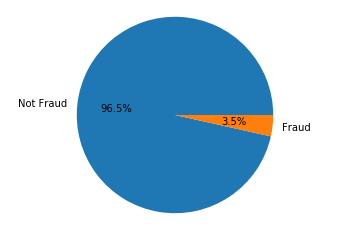

In [17]:
# Class imbalance check
plt.pie(train_transaction.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

Nota-se um grande desequilíbrio entre as duas classes. 

#### Exploring Continuous Features

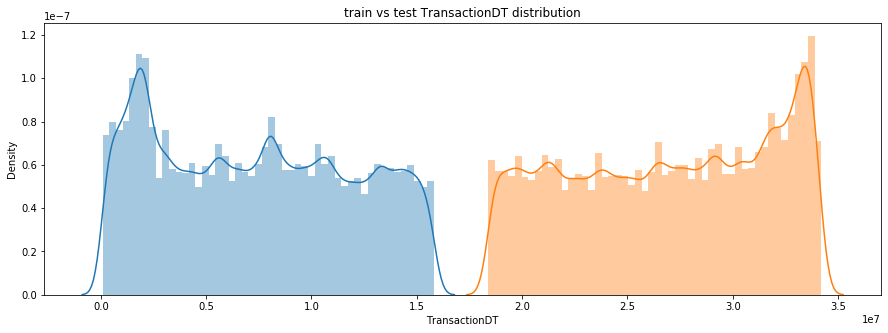

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(train_transaction["TransactionDT"])
sns.distplot(test_transaction["TransactionDT"])
plt.title('train vs test TransactionDT distribution')
plt.show()

Nota-se que o timestamp dos dados de teste está a frente do timestamp dos dados de treino. Portanto, ao treinar o modelo de machine learning, temos que fazer a divisão baseada em tempo para criar conjuntos de treinamento e validação. 

In [19]:
# Missing values check
combined_df = pd.concat([train_transaction.drop(columns=['isFraud', 'TransactionID']), test_transaction.drop(columns='TransactionID')])
print(combined_df.shape)

# Dependent variable
y = train_transaction['isFraud']
print(y.shape)

# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df, train_transaction, test_transaction
print(combined_mv_df.shape)



(1097231, 392)
(590540,)
(1097231, 180)


Os dados para analise ficaram com 180 colunas de 392 depois de remover recursos com mais de 20% de valores ausentes. Também foi removido com a coluna 'TransactionID', pois ela não tem importância na previsão. 
Para as colunas numéricas, o valor mediano será usado para preencher os valores ausentes.
Para as coluna categórica, a categoria mais frequente será usada para preencher os valores ausentes.

In [20]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
print(num_mv_df.shape)

# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
print(cat_mv_df.shape)
del combined_mv_df

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df
print(cat_df.shape)

# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
print(combined_df_cleaned.shape)
combined_df_cleaned.head()

(1097231, 176)
(1097231, 4)
(1097231, 176)
(1097231, 4)
Total missing values: 0
(1097231, 180)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V316,V317,V318,V319,V320,V321,ProductCD,card4,card6,P_emaildomain
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0.0,117.0,0.0,0.0,0.0,0.0,W,discover,credit,gmail.com
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,mastercard,credit,gmail.com
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,visa,debit,outlook.com
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,50.0,1404.0,790.0,0.0,0.0,0.0,W,mastercard,debit,yahoo.com
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,H,mastercard,credit,gmail.com


## Data Preprocessing

In [21]:
# One-hot encoding
combined_df_encoded = pd.get_dummies(combined_df_cleaned, drop_first=True)
print(combined_df_encoded.shape)
del combined_df_cleaned
combined_df_encoded.head()

(1097231, 245)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Separating train and test data
X = combined_df_encoded.iloc[:len(train_transaction)]
print(X.shape)
test = combined_df_encoded.iloc[len(train_transaction):]
print(test.shape)
del combined_df_encoded

(590540, 245)
(506691, 245)


In [25]:

# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
splitting_index = int(0.8*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
test = test.values
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del y, train



(472432, 245) (118108, 245) (472432,) (118108,)


In [26]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)
del X_train, X_val, test

# Class imbalance check
pd.value_counts(y_train)

0    455833
1     16599
dtype: int64

In [27]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(X_train_smote.shape, y_train_smote.shape)
del X_train_scaled, y_train
pd.value_counts(y_train_smote)

(911666, 245) (911666,)


0    455833
1    455833
dtype: int64

# ML Models

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve

## Random Forest Model


In [33]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

Validation AUC=0.888723976536408


In [34]:
score = accuracy_score(y_val, rfc.predict(X_val_scaled))
print("Model : Random Forest Classifier")
print('=====================================')
print('Accuracy : {:0.2f}'.format(score))
print('=====================================')
print('Recall_Score : {:0.2f}'.format(recall_score(y_val, rfc.predict(X_val_scaled))))
print('=====================================')
print('precission_Score : {:0.2f}'.format(precision_score(y_val, rfc.predict(X_val_scaled))))

Model : Random Forest Classifier
Accuracy : 0.97
Recall_Score : 0.43
precission_Score : 0.54


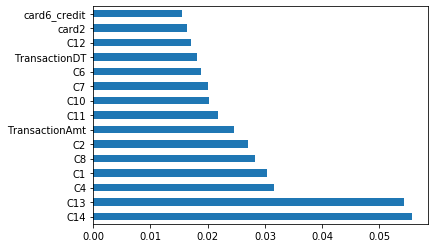

In [29]:
# Feature importances
pd.Series(rfc.feature_importances_, index=X.columns).nlargest(15).plot(kind='barh')
plt.show()

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

Validation AUC=0.888723976536408


In [42]:
score = accuracy_score(y_val, gbc.predict(X_val_scaled))
print("Model : GradientBoostingClassifier")
print('=====================================')
print('Accuracy : {:0.2f}'.format(score))
print('=====================================')
print('Recall_Score : {:0.2f}'.format(recall_score(y_val, gbc.predict(X_val_scaled))))
print('=====================================')
print('precission_Score : {:0.2f}'.format(precision_score(y_val, gbc.predict(X_val_scaled))))

Model : GradientBoostingClassifier
Accuracy : 0.92
Recall_Score : 0.55
precission_Score : 0.22
